In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import itertools

In [141]:
## Subset both the taxonomy dataframes.
nodeTax = pd.read_csv('../data/notebooks_out/viral_df_taxonomy.csv',index_col=0)

# A few rules for subsetting.

# Has to have family assigned at least
nodeTax = nodeTax[nodeTax['family'] != 'Unclassified']
# Has to fall in a 'insect infecting-like family'.
insectVirFam = ['Parvoviridae','Dicistroviridae','Rhabdoviridae',
               'Iflaviridae','Iridoviridae','Orthomyxoviridae','Nodaviridae','Phenuiviridae','Astroviridae']
nodeTax = nodeTax[nodeTax['family'].isin(insectVirFam)]

sraTax = pd.read_csv('../data/notebooks_out/viral_df_taxonomy_SRA.csv',index_col=0)
sraTax = sraTax[sraTax['family'] != 'Unclassified']
sraTax = sraTax[sraTax['family'].isin(insectVirFam)]

In [142]:
nodeTax + sraTax

,class,family,genus,no rank,order,phylum,species,subfamily,subphylum,superkingdom
BP10_NODE_253_length_1698_cov_0_733672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP10_NODE_316_length_1451_cov_0_490977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP10_NODE_548_length_1036_cov_0_413115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP11_NODE_41_length_1174_cov_1_003799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP12_NODE_196_length_807_cov_0_492711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
SRR935178.Contig_39352_166.482_length_559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR935178.Contig_8111_54.3373_length_521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR974922.Contig_2139_93.6595_length_6328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR974923.Contig_24030_37.9485_length_2041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
#Read in coverage matrix.
covmatsra = pd.read_csv("../data/Pcoa/SRA_df_coverage_lengthnorm.tsv", sep=',', index_col=0)
covmatbe = pd.read_csv("../data/Pcoa/flembee_df_coverage_lengthnorm.tsv", sep=",", index_col=0)
covmatbe = covmatbe.T
covmat = pd.concat([covmatsra, covmatbe], axis=0, join='outer')
covmat = covmat[covmat.columns.intersection(list(sraTax.index) + list(nodeTax.index))]

In [144]:
#Now we need information on the eukaryotic family of the host to begin with. For now we keep the flemish bee samples as seperate from apidae.
metadatdf = pd.read_csv("../data/Metadata_location_year_study_kind.csv", sep=";")
list(metadatdf[metadatdf['Tax_family'] == 'Formicidae']['Run'])

#We will only seperate families where we have more than 10 samples each, the others will be collapsed in an 'other'group.
#To start we just take the contig representatives.
Belgium_runs = list(covmatbe.index)
Formicidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Formicidae']['Run'])
Apidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Apidae']['Run'])
Vespidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Vespidae']['Run'])
Halictidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Halictidae']['Run'])
Braconidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Braconidae']['Run'])
Megachilidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Megachilidae']['Run'])
Pteromalidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Pteromalidae']['Run'])
Cephidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Cephidae']['Run'])
Figitidae_runs = list(metadatdf[metadatdf['Tax_family'] == 'Figitidae']['Run'])
Gathered = Belgium_runs + Formicidae_runs + Apidae_runs + Vespidae_runs + Halictidae_runs + Braconidae_runs + Megachilidae_runs + Pteromalidae_runs + Cephidae_runs + Figitidae_runs
Others_runs = []
for i in list(metadatdf['Run']):
    if i not in Gathered:
        Others_runs.append(i)

In [145]:
#Sanity test to see if we didn't miss anything:
len(covmat) == len(Belgium_runs) + len(Formicidae_runs) + len(Apidae_runs) + len(Vespidae_runs) + len(Halictidae_runs) + len(Braconidae_runs) + len(Megachilidae_runs) + len(Pteromalidae_runs) + len(Cephidae_runs) + len(Figitidae_runs) + len(Others_runs)

True

In [146]:
#Now subset the coverage matrix, so we have 1 matrix / eukaryotic family.
Belgium_cov = covmat[covmat.index.isin(Belgium_runs)]
Formicidae_cov = covmat[covmat.index.isin(Formicidae_runs)]
Apidae_cov = covmat[covmat.index.isin(Apidae_runs)]
Vespidae_cov = covmat[covmat.index.isin(Vespidae_runs)]
Halictidae_cov = covmat[covmat.index.isin(Halictidae_runs)]
Braconidae_cov = covmat[covmat.index.isin(Braconidae_runs)]
Megachilidae_cov = covmat[covmat.index.isin(Megachilidae_runs)]
Pteromalidae_cov = covmat[covmat.index.isin(Pteromalidae_runs)]
Cephidae_cov = covmat[covmat.index.isin(Cephidae_runs)]
Figitidae_cov = covmat[covmat.index.isin(Figitidae_runs)]
Others_cov = covmat[covmat.index.isin(Others_runs)]

<AxesSubplot:>

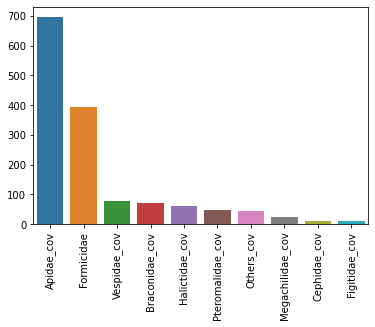

In [147]:
#Just get some barplots on the samples per eukaryotic family. This is quite skewed, but we assume that they are sampled completely. (This is a big flaw, but can't do anything about it).
famlen = [len(Apidae_cov) + len(Belgium_cov), len(Formicidae_cov),len(Vespidae_cov),len(Braconidae_cov),len(Halictidae_cov),len(Pteromalidae_cov),len(Others_cov),len(Megachilidae_cov),len(Cephidae_cov),len(Figitidae_cov)]
g = sns.barplot(x = ['Apidae_cov','Formicidae','Vespidae_cov','Braconidae_cov','Halictidae_cov','Pteromalidae_cov','Others_cov','Megachilidae_cov','Cephidae_cov','Figitidae_cov'], y=famlen)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g

In [148]:
#Now get lists of the representative contigs in each of the families.
# Depcrecated since we drop directionality anyway.

Belgium_contigs = []
for i in list(covmat.columns):
    if 'BP' in i or 'BeeP' in i:
        Belgium_contigs.append(i)
Formicidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Formicidae_runs:
        Formicidae_contigs.append(i)
Apidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Apidae_runs:
        Apidae_contigs.append(i)
Vespidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Vespidae_runs:
        Vespidae_contigs.append(i)
Halictidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Halictidae_runs:
        Halictidae_contigs.append(i)
Braconidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Braconidae_runs:
        Braconidae_contigs.append(i)
Megachilidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Megachilidae_runs:
        Megachilidae_contigs.append(i)
Pteromalidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Pteromalidae_runs:
        Pteromalidae_contigs.append(i)
Cephidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Cephidae_runs:
        Cephidae_contigs.append(i)
Figitidae_contigs  = []
for i in list(covmat.columns):
    if i.split('.')[0] in Figitidae_runs:
        Figitidae_contigs.append(i)
Others_contigs = []
for i in list(covmat.columns):
    if i.split('.')[0] in Others_runs:
        Others_contigs.append(i)

[1660, 399, 100, 79, 23, 14, 37, 2, 3, 0]
2317


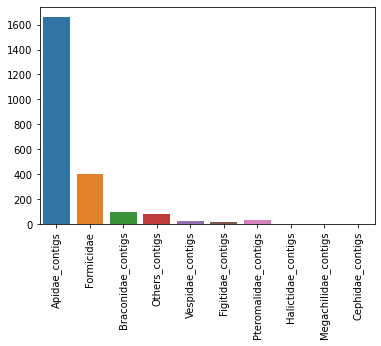

In [149]:
famlen = [len(Apidae_contigs) + len(Belgium_contigs), len(Formicidae_contigs),len(Braconidae_contigs),len(Others_contigs), len(Vespidae_contigs),len(Figitidae_contigs),len(Pteromalidae_contigs),len(Halictidae_contigs),len(Megachilidae_contigs),len(Cephidae_contigs)]
print(famlen)
g = sns.barplot(x = ['Apidae_contigs','Formicidae','Braconidae_contigs','Others_contigs','Vespidae_contigs','Figitidae_contigs','Pteromalidae_contigs','Halictidae_contigs','Megachilidae_contigs','Cephidae_contigs'], y=famlen)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g
print(sum(famlen))

In [150]:
#Sanity test to see if we have all contigs.
sum(famlen) == len(covmat.columns)

True

In [151]:
#now evaluate presence (defined as a relative count > 0.1 (assuming average of 100bp reads, this would be 10x covered, and the average is actually ~189))
#This treshold needs to be true for 10% of the samples of a particular family, and then it's appended.
#Create an edge list

# Combine the contigs.

Combinations = ['Apidae','Formicidae','Vespidae','Halictidae','Braconidae','Megachilidae','Pteromalidae','Cephidae','Figitidae','Others']
Apidae2_cov = pd.concat([Apidae_cov, Belgium_cov])

dfDic = {
    'Apidae': Apidae2_cov,
    'Formicidae': Formicidae_cov,
    'Vespidae': Vespidae_cov,
    'Halictidae': Halictidae_cov,
    'Braconidae': Braconidae_cov,
    'Megachilidae': Megachilidae_cov,
    'Pteromalidae': Pteromalidae_cov,
    'Cephidae': Cephidae_cov,
    'Figitidae': Figitidae_cov,
    'Others': Others_cov 
}


contigs = Belgium_contigs + \
    Formicidae_contigs + \
    Apidae_contigs + \
    Vespidae_contigs + \
    Halictidae_contigs + \
    Braconidae_contigs + \
    Megachilidae_contigs + \
    Pteromalidae_contigs + \
    Cephidae_contigs + \
    Figitidae_contigs + \
    Others_contigs

ShareLis = []
for comb in list(itertools.combinations(Combinations, 2)):
    df1 = dfDic[comb[0]]
    df2 = dfDic[comb[1]]
    
    df1Ret = df1[df1 > 0.1].count() > (0.05 * len(df1))
    df1_contigs = list(df1Ret[df1Ret!= False].index)
    
    df2Ret = df2[df2 > 0.1].count() > (0.05 * len(df2))
    df2_contigs = list(df2Ret[df2Ret!= False].index)
    
    SharedC = len(set.intersection(set(df1_contigs), set(df2_contigs)))
    ShareLis.append([comb[0], comb[1], SharedC])
ShareLis

[['Apidae', 'Formicidae', 85],
 ['Apidae', 'Vespidae', 98],
 ['Apidae', 'Halictidae', 8],
 ['Apidae', 'Braconidae', 156],
 ['Apidae', 'Megachilidae', 115],
 ['Apidae', 'Pteromalidae', 117],
 ['Apidae', 'Cephidae', 109],
 ['Apidae', 'Figitidae', 31],
 ['Apidae', 'Others', 119],
 ['Formicidae', 'Vespidae', 68],
 ['Formicidae', 'Halictidae', 6],
 ['Formicidae', 'Braconidae', 95],
 ['Formicidae', 'Megachilidae', 72],
 ['Formicidae', 'Pteromalidae', 76],
 ['Formicidae', 'Cephidae', 65],
 ['Formicidae', 'Figitidae', 27],
 ['Formicidae', 'Others', 85],
 ['Vespidae', 'Halictidae', 6],
 ['Vespidae', 'Braconidae', 111],
 ['Vespidae', 'Megachilidae', 86],
 ['Vespidae', 'Pteromalidae', 85],
 ['Vespidae', 'Cephidae', 76],
 ['Vespidae', 'Figitidae', 24],
 ['Vespidae', 'Others', 101],
 ['Halictidae', 'Braconidae', 8],
 ['Halictidae', 'Megachilidae', 6],
 ['Halictidae', 'Pteromalidae', 7],
 ['Halictidae', 'Cephidae', 5],
 ['Halictidae', 'Figitidae', 3],
 ['Halictidae', 'Others', 8],
 ['Braconidae', 'M

In [153]:
# Get number of contigs that exceed the threshold per family.
famDic = {}
for i in dfDic:
    stat = dfDic[i][dfDic[i] > 0.1].count() > (0.05 * len(dfDic[i]))
    famDic[i] = sum(stat)
print(famDic)

{'Apidae': 886, 'Formicidae': 142, 'Vespidae': 164, 'Halictidae': 9, 'Braconidae': 396, 'Megachilidae': 217, 'Pteromalidae': 324, 'Cephidae': 250, 'Figitidae': 96, 'Others': 221}


In [154]:
#Write to file, and process in cytoscape
with open('../networks/Hymenoptera_insect.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(ShareLis)

In [155]:
################### Now look inside 'Apidae' lineage.###################
#Runs: Belgium_runs (Apis Melifera), and Apidae Runs (all Apidae).
#Contigs: Belgium_contigs, Apidae_contigs
#coverage matrix: covmat.

metadatdf[metadatdf['Run'].isin(Apidae_runs)]['ScientificName'].unique()
Apidae_groups= {'Apis Mellifera':['Apis mellifera intermissa','Apis mellifera','Apis mellifera ligustica','Apis mellifera carnica','Apis mellifera mellifera','Apis mellifera scutellata','Apis mellifera capensis','Apis mellifera syriaca'], 
                'Ceratina':['Ceratina australensis','Ceratina calcarata'],
                'Tetragonula':['Tetragonula carbonaria'],
                'Bombus':['Bombus cryptarum','Bombus pyrosoma','Bombus terrestris','Bombus terrestris audax'],
                'Apis cerana': ['Apis cerana','Apis cerana cerana'],
                'Euglossa':['Euglossa flammea','Euglossa dilemma'],
                'Eulaema':['Eulaema bombiformis','Eulaema meriana'],
                'Eucera':['Eucera nigrescens','Eucera nigriceps','Eucera sp. ''Tetraloniella'' AD-2014'],
                'Apis florea':['Apis florea'],
                'Lepidotrigona':['Lepidotrigona ventralis']
               }

ApisMellifera_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Apis Mellifera'])]['Run']) + Belgium_runs
Ceratina_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Ceratina'])]['Run'])
Tetragonula_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Tetragonula'])]['Run'])
Bombus_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Bombus'])]['Run'])
ApisCerana_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Apis cerana'])]['Run'])
Euglossa_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Euglossa'])]['Run'])
Eulaema_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Eulaema'])]['Run'])
Eucera_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Eucera'])]['Run'])
ApisFlorea_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Apis florea'])]['Run'])
Lepidotrigona_Runs = list(metadatdf[metadatdf['ScientificName'].isin(Apidae_groups['Lepidotrigona'])]['Run'])

Mellifera_cov = covmat[covmat.index.isin(ApisMellifera_Runs)]
Ceratina_cov = covmat[covmat.index.isin(Ceratina_Runs)]
Tetragonula_cov = covmat[covmat.index.isin(Tetragonula_Runs)]
Bombus_cov = covmat[covmat.index.isin(Bombus_Runs)]
ApisCerana_cov = covmat[covmat.index.isin(ApisCerana_Runs)]
Euglossa_cov = covmat[covmat.index.isin(Euglossa_Runs)]
Eulaema_cov = covmat[covmat.index.isin(Eulaema_Runs)]
Eucera_cov = covmat[covmat.index.isin(Eucera_Runs)]
ApisFlorea_cov = covmat[covmat.index.isin(ApisFlorea_Runs)]
Lepidotrigona_cov = covmat[covmat.index.isin(Lepidotrigona_Runs)]


dfDic = {
    'Mellifera' : Mellifera_cov,
    'Ceratina' : Ceratina_cov,
    'Tetragonula' : Tetragonula_cov,
    'Bombus' : Bombus_cov,
    'ApisCerana' : ApisCerana_cov,
    'Euglossa' : Euglossa_cov,
    'Eulaema' : Eulaema_cov,
    'Eucera' : Eucera_cov,
    'ApisFlorea' : ApisFlorea_cov,
    'Lepidotrigona' : Lepidotrigona_cov
}
list(dfDic.keys())


Combinations = list(dfDic.keys())
Combinations

ShareLis_apidae = []
for comb in list(itertools.combinations(Combinations, 2)):
    df1 = dfDic[comb[0]]
    df2 = dfDic[comb[1]]
    
    df1Ret = df1[df1 > 0.1].count() > (0.05 * len(df1))
    df1_contigs = list(df1Ret[df1Ret!= False].index)
    
    df2Ret = df2[df2 > 0.1].count() > (0.05 * len(df2))
    df2_contigs = list(df2Ret[df2Ret!= False].index)
    
    SharedC = len(set.intersection(set(df1_contigs), set(df2_contigs)))
    ShareLis_apidae.append([comb[0], comb[1], SharedC])
ShareLis_apidae

[['Mellifera', 'Ceratina', 135],
 ['Mellifera', 'Tetragonula', 9],
 ['Mellifera', 'Bombus', 98],
 ['Mellifera', 'ApisCerana', 150],
 ['Mellifera', 'Euglossa', 45],
 ['Mellifera', 'Eulaema', 80],
 ['Mellifera', 'Eucera', 23],
 ['Mellifera', 'ApisFlorea', 463],
 ['Mellifera', 'Lepidotrigona', 160],
 ['Ceratina', 'Tetragonula', 10],
 ['Ceratina', 'Bombus', 115],
 ['Ceratina', 'ApisCerana', 113],
 ['Ceratina', 'Euglossa', 58],
 ['Ceratina', 'Eulaema', 84],
 ['Ceratina', 'Eucera', 27],
 ['Ceratina', 'ApisFlorea', 117],
 ['Ceratina', 'Lepidotrigona', 153],
 ['Tetragonula', 'Bombus', 10],
 ['Tetragonula', 'ApisCerana', 8],
 ['Tetragonula', 'Euglossa', 8],
 ['Tetragonula', 'Eulaema', 10],
 ['Tetragonula', 'Eucera', 6],
 ['Tetragonula', 'ApisFlorea', 8],
 ['Tetragonula', 'Lepidotrigona', 11],
 ['Bombus', 'ApisCerana', 72],
 ['Bombus', 'Euglossa', 43],
 ['Bombus', 'Eulaema', 66],
 ['Bombus', 'Eucera', 18],
 ['Bombus', 'ApisFlorea', 77],
 ['Bombus', 'Lepidotrigona', 119],
 ['ApisCerana', 'Eugloss

In [156]:
# Get number of contigs that exceed the threshold per family.
famDic = {}
for i in dfDic:
    stat = dfDic[i][dfDic[i] > 0.1].count() > (0.05 * len(dfDic[i]))
    famDic[i] = sum(stat)
print(famDic)

{'Mellifera': 926, 'Ceratina': 373, 'Tetragonula': 11, 'Bombus': 224, 'ApisCerana': 326, 'Euglossa': 92, 'Eulaema': 149, 'Eucera': 41, 'ApisFlorea': 584, 'Lepidotrigona': 354}


In [120]:
#Write to file, and process in cytoscape
with open('../networks/Apidae_insect.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(ShareLis_apidae)

In [121]:
len(contigs)

2317